## Train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

In [2]:
year = 2018
dfDemand = pd.read_csv("ERCOT_" + str(year) + "_Hourly_Wind_Output" + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)

Hourly demand data loaded for 365 days.


Understand the data

Text(0, 0.5, 'Net demand of Texas (in MW)')

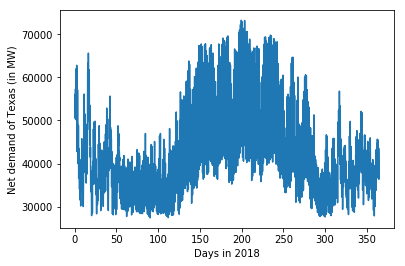

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

The first day in the first plot is Jan 31, 2018.
Day 1 was a Wednesday.


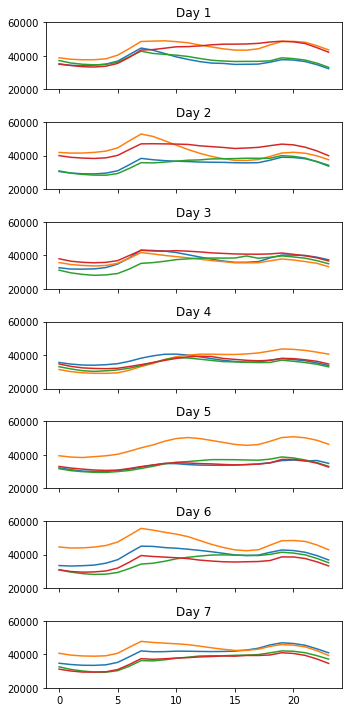

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

The first day in the first plot is August 15, 2018.
Day 1  was a  Wednesday.


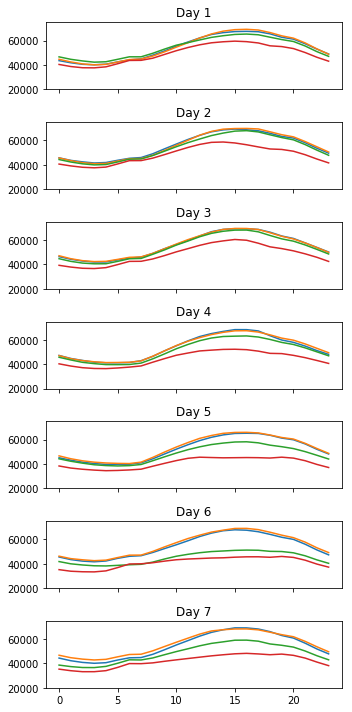

In [5]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Set up Train/Test Data

The features we will use to predict energy load on day t are energy load at day t - 7, t - 2 and t - 1

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]

In [7]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
trainX = preprocessing.StandardScaler().fit_transform(trainX)
testX = preprocessing.StandardScaler().fit_transform(testX)

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

Neural network will train on data from 286 days, and test on 72 days.


Neural Network with one hidden layer, there are various things we can choose to tune:

Number of neurons (nHidden)

relu or sigmoid

Number of Hidden Layers

learning rate

loss function

optimzer

In [8]:
nHidden = 72 #tunable

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights, biases, and outputs (Z1 using relu) of the first layer.

W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.truncated_normal(shape=[nHidden]))
Z1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(Z1, 0.995)

# Define the weights, biases, and outputs (Z2 as a function of outputLayer1 using relu) of the second layer.

W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.truncated_normal(shape=[nDimY])) #1
Z2 = tf.nn.relu(tf.matmul(Z1, W2) + b2)

# Define the output of layer 2.
outputNN = tf.nn.dropout(Z2, 0.995)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

#insert code
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.4).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)


Train the Neural Network

things we could change:

batch size (batchSize)

number of Epochs (nEpochs)

In [9]:
import time
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")
    start = time.time()
    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))
    print("time:", time.time() - start, "secs")
    print("Training process completed.")

Started the training module.
Epoch: 200 - Average loss in last epoch = 100895916.8
Epoch: 400 - Average loss in last epoch = 49978978.4
Epoch: 600 - Average loss in last epoch = 38136920.8
Epoch: 800 - Average loss in last epoch = 31747522.4
Epoch: 1000 - Average loss in last epoch = 26798444.0
Epoch: 1200 - Average loss in last epoch = 23183875.2
Epoch: 1400 - Average loss in last epoch = 19191110.6
Epoch: 1600 - Average loss in last epoch = 17858163.8
Epoch: 1800 - Average loss in last epoch = 20572934.8
Epoch: 2000 - Average loss in last epoch = 19578367.8
Epoch: 2200 - Average loss in last epoch = 21397758.2
Epoch: 2400 - Average loss in last epoch = 19716818.8
Epoch: 2600 - Average loss in last epoch = 16889221.6
Epoch: 2800 - Average loss in last epoch = 14153183.8
Epoch: 3000 - Average loss in last epoch = 18065357.6
Epoch: 3200 - Average loss in last epoch = 13218452.8
Epoch: 3400 - Average loss in last epoch = 17651047.6
Epoch: 3600 - Average loss in last epoch = 16646187.2
Ep

Test the accuracy of our predictions

In [10]:
predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  3539.6794


## Visualize the results

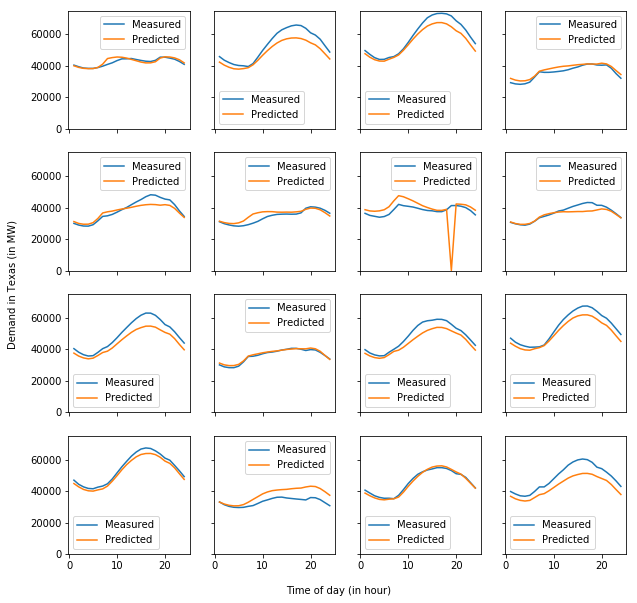

In [11]:
# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()

for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
        
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()
    
fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')
    
plt.show()